In [ ]:
## Generate train_data

In [16]:
import os
import numpy as np
import pandas as pd
import cv2 as cv

In [17]:
from skimage.io import imshow, imread, imsave
import dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../01_dataset_GENKI_4K/shape_predictor_68_face_landmarks.dat')

In [50]:

def find_pts(img_path, verbose=0, is_show=False , is_tag=False, is_normalize=False):
#     img = imread(pd_face.iloc[9]['path'])
    img = imread(img_path)
    pts = []
    
    dets = detector(img, 1)
    if verbose > 0:
        print(f'image shape: {str(img.shape)}')
        print('Number of faces detected: {}'.format(len(dets)))
    for i, face in enumerate(dets):
        if verbose > 0:
            print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} ".format(
                i, face.left(), face.top(), face.right(), face.bottom()))
            print(f"aspect_ratio:{(face.bottom() - face.top()) / (face.right() -  face.left())}")
        if is_tag:
            img = cv.rectangle(img.copy(), (face.left(), face.top()), (face.right(), face.bottom()), (255, 0, 0), 1)
#             cv2.rectangle(img, (face.left(), face.top()), (face.right(), face.bottom()), (0, 255, 0), 1)
            
        shape = predictor(img, face)
        face_width = face.right() - face.left()
        face_height = face.bottom() - face.top()

        for i in range(68):
            if is_tag:
                img = cv.circle(img.copy(), (shape.part(i).x, shape.part(i).y), 1, (0,0,255), 1)
                cv.putText(img,str(i), (shape.part(i).x,shape.part(i).y), cv.FONT_HERSHEY_COMPLEX, 0.25, (0,255,0), 1)
            x = shape.part(i).x
            y = shape.part(i).y
            if is_normalize:
                # Should be changed because the total image should base on face, not origin pic
                x = (shape.part(i).x - face.left()) / face_width
                y = (shape.part(i).y - face.top()) / face_height
#             pts.append([x, y])
            pts.extend([x, y])
        break
        
    if is_show:
        imshow(img)
    
    return pts

image shape: (192, 180, 3)
Number of faces detected: 1
Detection 0: Left: 46 Top: 66 Right: 135 Bottom: 156 
aspect_ratio:1.0112359550561798


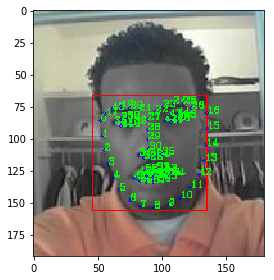

In [51]:
img_path_root = './faces'
img_paths = []
for root, dirs, files in os.walk(img_path_root):
    for file in files:
        img_paths.append(os.path.join(root, file)) 
        
result = find_pts(img_paths[0], is_show=True, is_tag=True, verbose=1, is_normalize=True)

In [54]:
print(result[2], result[59])

0.07865168539325842 0.37777777777777777


In [69]:
def gen_train_data():
    
    img_path_root = './faces'
    img_paths = []
    feature_pts = []
    for root, dirs, files in os.walk(img_path_root):
        for file in files:
#             img_paths.append(os.path.join(root, file))
            data_list = [file[4:8]]
            data_list.extend(find_pts(os.path.join(root, file), is_normalize=True))

            feature_pts.append(data_list)

    feature_pts = sorted(feature_pts, key=lambda x: x[0], reverse=False)
    train_x = pd.DataFrame(feature_pts, columns=list(range(len(feature_pts[0]))))
    return train_x

In [70]:
train_x = gen_train_data()

In [108]:
# train_x.set_index(0, inplace=True)
# train_x.reset_index(inplace=True)
train_x.head()

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
0,0001,0.044944,0.288889,0.067416,0.411111,0.078652,0.533333,0.112360,0.655556,0.168539,...,0.595506,0.611111,0.741573,0.611111,0.595506,0.688889,0.528090,0.688889,0.471910,0.688889
1,0002,0.067568,0.346667,0.094595,0.466667,0.108108,0.573333,0.135135,0.693333,0.175676,...,0.567568,0.666667,0.675676,0.680000,0.567568,0.746667,0.513514,0.746667,0.459459,0.746667
2,0003,0.027778,0.222222,0.027778,0.333333,0.027778,0.444444,0.027778,0.583333,0.083333,...,0.527778,0.666667,0.638889,0.666667,0.527778,0.722222,0.472222,0.722222,0.416667,0.722222
3,0004,0.053333,0.240000,0.053333,0.386667,0.053333,0.533333,0.053333,0.666667,0.080000,...,0.560000,0.760000,0.653333,0.786667,0.560000,0.840000,0.493333,0.840000,0.440000,0.826667
4,0005,-0.040541,0.283784,-0.013514,0.405405,0.040541,0.540541,0.067568,0.648649,0.121622,...,0.621622,0.581081,0.729730,0.554054,0.635135,0.675676,0.567568,0.702703,0.486486,0.716216


In [81]:
# train_x.to_csv('./68pts_normed.csv')

In [101]:
labels = pd.read_csv('../01_dataset_GENKI_4K/labels.csv')[['is_smile']]

In [113]:
# dataset = train_x.concat(labels, join='outer')
# dataset = pd.merge(train_x, labels, left_index=True, right_index=True, how='outer')

dataset = pd.merge(train_x, labels, left_index=True, right_index=True)
dataset.set_index(0, inplace=True)
dataset.dropna(inplace=True)

In [120]:
img_df = dataset[dataset.columns.tolist()[:-1]]
label_df = dataset[['is_smile']]

In [121]:
# labels.shape
img_df.shape

(3884, 136)

In [122]:
label_df.shape

(3884, 1)

## Modeling

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib


In [125]:
X_train, X_val, Y_train, Y_val = train_test_split(img_df, label_df, test_size=0.3)

In [126]:
# svm_model = svm.SVC(kernel='sigmoid', degree=3, tol=1e-6, verbose=True).fit(X_train, Y_train)
svm_model = LinearSVC(multi_class='ovr', penalty='l2', tol=1e-6, verbose=1).fit(X_train, Y_train)

accuracy_score(y_true=Y_val, y_pred=svm_model.predict(X_val))

[LibLinear]

0.9451114922813036

In [128]:
joblib.dump(svm_model, './68pts_svm.joblib')

['../base_classifications/68pts_svm.joblib']